In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
#use tf gpu 1.9.0, 1.12.0 gives cudnn version mismatch error

Using TensorFlow backend.


In [2]:
#check data
def load_text_captions(filename):
    file = open(filename, 'r', encoding="ISO-8859-1")
    text = file.read()
    file.close()
    return text

filename = "dataset/30k_captions.txt"
text_captions = load_text_captions(filename)
print(text_captions[:357])

1000092795.jpg#0	Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg#1	Two young , White males are outside near many bushes .
1000092795.jpg#2	Two men in green shirts are standing in a yard .
1000092795.jpg#3	A man in a blue shirt standing in a garden .
1000092795.jpg#4	Two friends enjoy time spent together .


In [3]:
# make key:value pairs for filename:5x captions
def load_filename_dict(text_captions):
    dictonary = dict()
    for line in text_captions.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        #first token = image id
        image_id, image_desc = tokens[0], tokens[1:]
        # remove .jpg
        image_id = image_id.split('.')[0]
        # description to string
        image_desc = ' '.join(image_desc)
        if image_id not in dictonary:
            dictonary[image_id] = list()
        dictonary[image_id].append(image_desc)
    return dictonary

descriptions = load_filename_dict(text_captions)
print('Loaded: %d ' % len(descriptions))

Loaded: 31783 


In [4]:
list(descriptions.keys())[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [5]:
descriptions['1000092795']

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young , White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [6]:
def clean_descriptions(descriptions):
    # translation table for removing punctuation; third param for removal
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            # using trans table to remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove s/a
            desc = [word for word in desc if len(word)>1]
            # words with nos
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [7]:
descriptions['1000092795']

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two young white males are outside near many bushes',
 'two men in green shirts are standing in yard',
 'man in blue shirt standing in garden',
 'two friends enjoy time spent together']

In [8]:
# vocab words
def to_vocab(descriptions):
    #all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocab(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 19734


In [36]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'dataset/descriptions.txt')

In [9]:
# load train ids
def load_set(filename):
    doc = load_text_captions(filename)
    dataset = list()
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

filename = 'dataset/flickr30k_train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 29000


In [10]:
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_text_captions(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions('dataset/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=29000


In [11]:
train_descriptions['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [12]:
# all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

145000

In [13]:
# words appearing at least 10 times
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 19062 -> 5227


In [8]:
# inception v3 model
model = InceptionV3(weights='imagenet')

# remove the last layer (output layer) from inception v3; [-1] = last layer's output, [-2] = last layer
model_new = Model(model.input, model.layers[-2].output)

In [14]:
def preprocess(image_path):
    # 299x299 needed by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [15]:
# encode image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [16]:
# all the images
images = 'dataset/flickr30k-images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [17]:
train_images_file = 'dataset/flickr30k_train.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [18]:
test_images_file = 'dataset/flickr30k_test.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [15]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 1462.748862504959


In [20]:
# Save bottleneck train features
with open("dataset/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [21]:
# for test imgs 
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 62.08194947242737


In [22]:
# Save bottleneck test features
with open("dataset/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [19]:
train_features = load(open("dataset/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=29000


In [20]:
# word to index and vice versa
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [21]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

5228

In [22]:
# dict desc to list desc
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# max len of desc
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 74


In [23]:
# data generator, intended to be used in a call to model.fit_generator()
# as we cannot load the whole data martix of n*m into ram; 210000 * 8848= 1858080000 blocks.
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [24]:
# Load Glove vectors
glove_dir = 'dataset/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_dim = 200

# Get 200-dim dense vector each word in our vocab
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix.shape

(5228, 200)

In [49]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [50]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 74)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 74, 200)      1045600     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 

In [51]:
# embedding matrix from pre-trained Glove 
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [53]:
epochs = 10 #10 + 10 for lr 0.001, then 10 for lr 0.0001
#model.optimizer.lr = 0.1 #testing
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [54]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('model_weights_tweak/model_' + str(i) + '.h5')

Epoch 1/1
9666/9666 [==============================] - 1661s 172ms/step - loss: 4.1875
Epoch 1/1
9666/9666 [==============================] - 1652s 171ms/step - loss: 3.6972
Epoch 1/1
9666/9666 [==============================] - 1652s 171ms/step - loss: 3.5862
Epoch 1/1
9666/9666 [==============================] - 1650s 171ms/step - loss: 3.5368
Epoch 1/1
9666/9666 [==============================] - 1649s 171ms/step - loss: 3.5083
Epoch 1/1
9666/9666 [==============================] - 1651s 171ms/step - loss: 3.4903
Epoch 1/1
9666/9666 [==============================] - 1650s 171ms/step - loss: 3.4798
Epoch 1/1
9666/9666 [==============================] - 1660s 172ms/step - loss: 3.4731
Epoch 1/1
9666/9666 [==============================] - 1653s 171ms/step - loss: 3.4681
Epoch 1/1
9666/9666 [==============================] - 1653s 171ms/step - loss: 3.4644


In [55]:
model.save_weights('./model_weights/2/model_10_final.h5')

In [23]:
epochs = 10 #10 + 10 for lr 0.001, then 10 for lr 0.0001
# model.optimizer.lr = 0.1 #testing
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [56]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
#     model.save('./model_weights_tweak/model_' + str(i) + '.h5')

Epoch 1/1
9666/9666 [==============================] - 1659s 172ms/step - loss: 3.4641
Epoch 1/1
9666/9666 [==============================] - 1659s 172ms/step - loss: 3.4626
Epoch 1/1
9666/9666 [==============================] - 1655s 171ms/step - loss: 3.4629
Epoch 1/1
9666/9666 [==============================] - 1665s 172ms/step - loss: 3.4623
Epoch 1/1
9666/9666 [==============================] - 1652s 171ms/step - loss: 3.4615
Epoch 1/1
9666/9666 [==============================] - 1657s 171ms/step - loss: 3.4635
Epoch 1/1
9666/9666 [==============================] - 1655s 171ms/step - loss: 3.4635
Epoch 1/1
9666/9666 [==============================] - 1675s 173ms/step - loss: 3.4638
Epoch 1/1
9666/9666 [==============================] - 1677s 173ms/step - loss: 3.4662
Epoch 1/1
9666/9666 [==============================] - 1661s 172ms/step - loss: 3.4689


In [57]:
model.save_weights('./model_weights/2/model_20_final.h5')

In [58]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [59]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
4833/4833 [==============================] - 923s 191ms/step - loss: 3.4246
Epoch 1/1
4833/4833 [==============================] - 916s 190ms/step - loss: 3.4125
Epoch 1/1
4833/4833 [==============================] - 927s 192ms/step - loss: 3.4007
Epoch 1/1
4833/4833 [==============================] - 919s 190ms/step - loss: 3.3927
Epoch 1/1
4833/4833 [==============================] - 910s 188ms/step - loss: 3.3872
Epoch 1/1
4833/4833 [==============================] - 905s 187ms/step - loss: 3.3807
Epoch 1/1
4833/4833 [==============================] - 947s 196ms/step - loss: 3.3774
Epoch 1/1
4833/4833 [==============================] - 920s 190ms/step - loss: 3.3720
Epoch 1/1
4833/4833 [==============================] - 914s 189ms/step - loss: 3.3691
Epoch 1/1
4833/4833 [==============================] - 925s 191ms/step - loss: 3.3659


In [60]:
model.save_weights('./model_weights/2/model_30_final.h5')

In [61]:
model.load_weights('./model_weights/2/model_30_final.h5')

In [62]:
images = 'dataset/flickr30k-images/'

In [63]:
with open("dataset/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [64]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

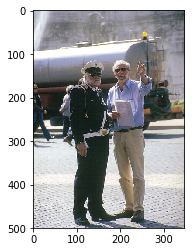

man in blue shirt is standing in front of building with graffiti on it


In [71]:
z=41
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))